# DEEPCAMP_P1D_LSTM
### Objectif_Notebook : Conception et entraînement des modèles LSTM sans prédictions Météo France

## 1.Importer Librairies

In [ ]:

#####################################################################################################
#  import 
#####################################################################################################
import pandas as pd
import numpy as np
from numpy import concatenate
from matplotlib import pyplot

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# design lstm
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf



## 2.Importer Données

In [ ]:
#LOAD TRAIN DATA
dataframe = pd.read_csv('/content/DataWithoutNanV4.csv')

del dataframe['Id']
del dataframe['date']
del dataframe['number_sta']

In [ ]:
dataframe.head(2)

,ff,lt,td,hu,dd,precip,Ground_truth
0,3.91375,280.333750,278.514583,88.591667,146.500,0.008333,3.4
1,8.04125,282.936667,279.997500,82.300000,205.625,0.141667,11.7


## 3.Convertir séries temporelles pour LSTM

In [ ]:
# values 
values = dataframe.values
# encoder 
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values[:,4]
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#function for series to supervised conversion :
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't need for LSTM 
reframed.drop(reframed.columns[[6,7,8,9,10,11,12]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var7(t)
1   0.160655   0.432794   0.691741   0.884764   0.338439   0.002139  0.125134
2   0.330084   0.484125   0.711108   0.821212   0.542413   0.036364  0.010695
3   0.222023   0.417495   0.678463   0.866162   0.558652   0.064171  0.059893
4   0.176356   0.467880   0.684296   0.761700   0.304853   0.124064  0.034225
5   0.072024   0.481528   0.724245   0.886322   0.402903   0.059893  0.008556


## 4.Construire le jeu d'entrainement

In [ ]:


#build train
train_size = int(len(reframed)*0.8)
train = reframed[0:train_size]

# split into input and outputs
train_X, train_y =  train.loc[:, train.columns != 'var7(t)'],train[['var7(t)']]

# convert to array
train_X, train_y = np.array(train_X),np.array(train_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

print("reshape input to be 3D [samples, timesteps, features]")
print(train_X.shape, train_y.shape)


reshape input to be 3D [samples, timesteps, features]
(146982, 1, 6) (146982, 1)


In [ ]:
#build train
test_size = int(len(reframed)*0.2)
test = reframed[0:test_size]

# split into input and outputs
test_X, test_y =  test.loc[:, test.columns != 'var7(t)'],test[['var7(t)']]


# convert to array
test_X, test_y= np.array(test_X),np.array(test_y)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X.shape, test_y.shape)

(36745, 1, 6) (36745, 1)


## 6.Modélisation LSTM

In [ ]:
#mape error 
def custom_loss_function(y_true, y_pred):
  return tf.math.reduce_mean(tf.abs((y_true+1)-(y_pred+1))/(y_true+1))*100

### 6.1.Baseline Vanilla Model


#### 6.1.1.Conception du model vanilla

In [ ]:
print('Lookback:',train_X.shape[1])
print('Number of features:',train_X.shape[2])

Lookback: 1
Number of features: 6


In [ ]:
# LSTM parameters 
lookback = train_X.shape[1]
hidden_units= 256
nb_features = train_X.shape[2]

#designing vanilla model
vanilla_model = Sequential()
vanilla_model.add(LSTM(hidden_units, input_shape=(lookback, nb_features)))
vanilla_model.add(Dense(1))

#compiling model
vanilla_model.compile(loss=custom_loss_function, optimizer='adam',metrics=custom_loss_function)





#### 6.1.2.Entrainer le model vanilla 

Epoch 1/10
2042/2042 - 19s - loss: 1.9485 - custom_loss_function: 1.9481 - val_loss: 1.9139 - val_custom_loss_function: 1.9133 - 19s/epoch - 9ms/step
Epoch 2/10
2042/2042 - 15s - loss: 1.8870 - custom_loss_function: 1.8866 - val_loss: 1.8706 - val_custom_loss_function: 1.8700 - 15s/epoch - 8ms/step
Epoch 3/10
2042/2042 - 15s - loss: 1.8736 - custom_loss_function: 1.8732 - val_loss: 1.8630 - val_custom_loss_function: 1.8624 - 15s/epoch - 8ms/step
Epoch 4/10
2042/2042 - 18s - loss: 1.8673 - custom_loss_function: 1.8669 - val_loss: 1.8626 - val_custom_loss_function: 1.8620 - 18s/epoch - 9ms/step
Epoch 5/10
2042/2042 - 21s - loss: 1.8647 - custom_loss_function: 1.8643 - val_loss: 1.8625 - val_custom_loss_function: 1.8619 - 21s/epoch - 10ms/step
Epoch 6/10
2042/2042 - 15s - loss: 1.8629 - custom_loss_function: 1.8625 - val_loss: 1.8628 - val_custom_loss_function: 1.8622 - 15s/epoch - 7ms/step
Epoch 7/10
2042/2042 - 20s - loss: 1.8621 - custom_loss_function: 1.8617 - val_loss: 1.8604 - val_c

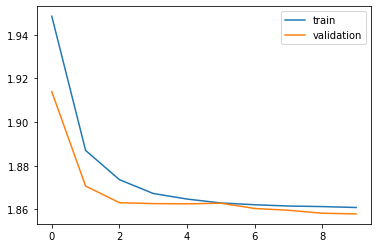

In [ ]:
# fit network
history = vanilla_model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

#### 6.1.3. Faire prédictions

In [ ]:
# make a prediction
yhat = vanilla_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('score mape of vanilla model : ',custom_loss_function(inv_y,inv_yhat))


In [ ]:
print('score mape of vanilla model : ',custom_loss_function(inv_y,inv_yhat))


score mape of vanilla model :  tf.Tensor(18.888186, shape=(), dtype=float32)


### 6.2. Stacked Model

#### 6.2.1. Conception du stacked model

In [ ]:
# LSTM parameters 
lookback = train_X.shape[1]
hidden_units= 256
nb_features = train_X.shape[2]

#designing stacked model
stacked_model = Sequential()
stacked_model.add(LSTM(256,activation='tanh', return_sequences=True, input_shape=(lookback, nb_features)))
stacked_model.add(LSTM(256,activation='tanh'))
stacked_model.add(Dense(1))

#compiling model
stacked_model.compile(loss=custom_loss_function, optimizer='adam',metrics=custom_loss_function)

#### 6.2.2. Entrainement du stacked model

Epoch 1/10
2042/2042 - 47s - loss: 1.8785 - custom_loss_function: 1.8781 - val_loss: 1.8686 - val_custom_loss_function: 1.8680 - 47s/epoch - 23ms/step
Epoch 2/10
2042/2042 - 35s - loss: 1.8661 - custom_loss_function: 1.8658 - val_loss: 1.8645 - val_custom_loss_function: 1.8639 - 35s/epoch - 17ms/step
Epoch 3/10
2042/2042 - 36s - loss: 1.8621 - custom_loss_function: 1.8618 - val_loss: 1.8700 - val_custom_loss_function: 1.8694 - 36s/epoch - 17ms/step
Epoch 4/10
2042/2042 - 36s - loss: 1.8613 - custom_loss_function: 1.8610 - val_loss: 1.8690 - val_custom_loss_function: 1.8683 - 36s/epoch - 18ms/step
Epoch 5/10
2042/2042 - 37s - loss: 1.8600 - custom_loss_function: 1.8596 - val_loss: 1.8656 - val_custom_loss_function: 1.8649 - 37s/epoch - 18ms/step
Epoch 6/10
2042/2042 - 36s - loss: 1.8597 - custom_loss_function: 1.8593 - val_loss: 1.8631 - val_custom_loss_function: 1.8625 - 36s/epoch - 18ms/step
Epoch 7/10
2042/2042 - 36s - loss: 1.8586 - custom_loss_function: 1.8583 - val_loss: 1.8619 - 

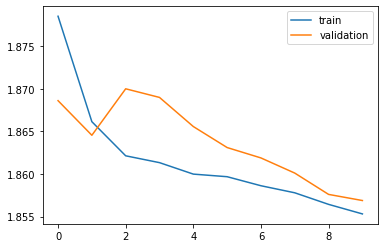

In [ ]:
# fit network
history = stacked_model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

#### 6.2.3. Prédictions du stacked model

In [ ]:
# make a prediction
yhat = stacked_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('score mape of stacked model : ',custom_loss_function(inv_y,inv_yhat))


score mape of stacked model :  tf.Tensor(19.007591, shape=(), dtype=float32)


### 6.3. Bidirectional model

#### 6.3.1. Conception du bidirectional model

In [ ]:
bidir_model = Sequential()
bidir_model.add(Bidirectional(LSTM(256, activation='tanh'), input_shape=(lookback,nb_features)))
bidir_model.add(Dense(1))

#compiling model
bidir_model.compile(loss=custom_loss_function, optimizer='adam',metrics=custom_loss_function)

#### 6.3.2. Entrainement  du bidirectional model

Epoch 1/10
2042/2042 - 33s - loss: 1.9785 - custom_loss_function: 1.9781 - val_loss: 1.8662 - val_custom_loss_function: 1.8656 - 33s/epoch - 16ms/step
Epoch 2/10
2042/2042 - 28s - loss: 1.8965 - custom_loss_function: 1.8962 - val_loss: 1.8825 - val_custom_loss_function: 1.8819 - 28s/epoch - 14ms/step
Epoch 3/10
2042/2042 - 31s - loss: 1.8759 - custom_loss_function: 1.8756 - val_loss: 1.8638 - val_custom_loss_function: 1.8632 - 31s/epoch - 15ms/step
Epoch 4/10
2042/2042 - 28s - loss: 1.8684 - custom_loss_function: 1.8681 - val_loss: 1.8640 - val_custom_loss_function: 1.8634 - 28s/epoch - 14ms/step
Epoch 5/10
2042/2042 - 28s - loss: 1.8648 - custom_loss_function: 1.8644 - val_loss: 1.8636 - val_custom_loss_function: 1.8630 - 28s/epoch - 14ms/step
Epoch 6/10
2042/2042 - 28s - loss: 1.8633 - custom_loss_function: 1.8630 - val_loss: 1.8620 - val_custom_loss_function: 1.8614 - 28s/epoch - 14ms/step
Epoch 7/10
2042/2042 - 29s - loss: 1.8623 - custom_loss_function: 1.8619 - val_loss: 1.8618 - 

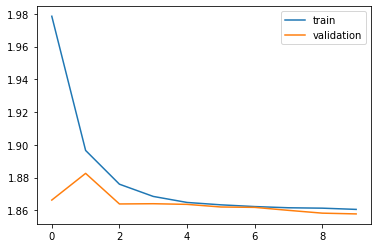

In [ ]:
# fit network
history = bidir_model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

#### 6.3.3. Prédictions du bidirectional model

In [ ]:
# make a prediction
yhat = bidir_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('score mape of bidirectional model : ',custom_loss_function(inv_y,inv_yhat))

score mape of bidirectional model :  tf.Tensor(18.894075, shape=(), dtype=float32)


### 6.4. Vanilla with Drop out 


In [ ]:
# LSTM parameters 
lookback = 1
hidden_units= 256
nb_features = 6

#designing vanilla model
vanilla_model_dr = Sequential()
vanilla_model_dr.add(LSTM(hidden_units, input_shape=(lookback, nb_features)))
vanilla_model_dr.add(Dropout(0.2))
vanilla_model_dr.add(Dense(1))

#compiling model
vanilla_model_dr.compile(loss=custom_loss_function, optimizer='adam',metrics=custom_loss_function)

Epoch 1/10
2042/2042 - 25s - loss: 1.9385 - custom_loss_function: 1.9381 - val_loss: 1.8649 - val_custom_loss_function: 1.8643 - 25s/epoch - 12ms/step
Epoch 2/10
2042/2042 - 21s - loss: 1.8695 - custom_loss_function: 1.8692 - val_loss: 1.8670 - val_custom_loss_function: 1.8664 - 21s/epoch - 10ms/step
Epoch 3/10
2042/2042 - 23s - loss: 1.8669 - custom_loss_function: 1.8666 - val_loss: 1.8658 - val_custom_loss_function: 1.8652 - 23s/epoch - 12ms/step
Epoch 4/10
2042/2042 - 22s - loss: 1.8652 - custom_loss_function: 1.8649 - val_loss: 1.8632 - val_custom_loss_function: 1.8626 - 22s/epoch - 11ms/step
Epoch 5/10
2042/2042 - 21s - loss: 1.8639 - custom_loss_function: 1.8636 - val_loss: 1.8636 - val_custom_loss_function: 1.8630 - 21s/epoch - 10ms/step
Epoch 6/10
2042/2042 - 21s - loss: 1.8631 - custom_loss_function: 1.8628 - val_loss: 1.8611 - val_custom_loss_function: 1.8605 - 21s/epoch - 10ms/step
Epoch 7/10
2042/2042 - 22s - loss: 1.8631 - custom_loss_function: 1.8627 - val_loss: 1.8596 - 

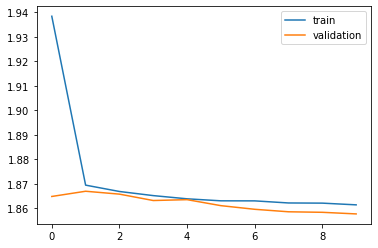

In [ ]:
# fit network
history = vanilla_model_dr.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = vanilla_model_dr.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('score mape of bidirectional model : ',custom_loss_function(inv_y,inv_yhat))

score mape of bidirectional model :  tf.Tensor(18.841953, shape=(), dtype=float32)


### 6.5. Vanilla with Weight Decay

In [ ]:
# LSTM parameters 
lookback = 1
hidden_units= 256
nb_features = 6

#designing vanilla model
vanilla_model_wd = Sequential()
vanilla_model_wd.add(LSTM(hidden_units, input_shape=(lookback, nb_features)))
vanilla_model_wd.add(Dense(1, kernel_regularizer=l2(0.001)))

#compiling model
vanilla_model_wd.compile(loss=custom_loss_function, optimizer='adam',metrics=custom_loss_function)

Epoch 1/10
2042/2042 - 27s - loss: 1.9462 - custom_loss_function: 1.9446 - val_loss: 1.8979 - val_custom_loss_function: 1.8966 - 27s/epoch - 13ms/step
Epoch 2/10
2042/2042 - 21s - loss: 1.8855 - custom_loss_function: 1.8845 - val_loss: 1.8712 - val_custom_loss_function: 1.8702 - 21s/epoch - 10ms/step
Epoch 3/10
2042/2042 - 20s - loss: 1.8742 - custom_loss_function: 1.8736 - val_loss: 1.8637 - val_custom_loss_function: 1.8629 - 20s/epoch - 10ms/step
Epoch 4/10
2042/2042 - 20s - loss: 1.8677 - custom_loss_function: 1.8672 - val_loss: 1.8625 - val_custom_loss_function: 1.8618 - 20s/epoch - 10ms/step
Epoch 5/10
2042/2042 - 21s - loss: 1.8655 - custom_loss_function: 1.8651 - val_loss: 1.8629 - val_custom_loss_function: 1.8622 - 21s/epoch - 10ms/step
Epoch 6/10
2042/2042 - 20s - loss: 1.8634 - custom_loss_function: 1.8630 - val_loss: 1.8621 - val_custom_loss_function: 1.8614 - 20s/epoch - 10ms/step
Epoch 7/10
2042/2042 - 19s - loss: 1.8625 - custom_loss_function: 1.8620 - val_loss: 1.8616 - 

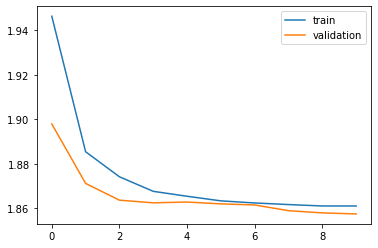

In [ ]:
# fit network
history = vanilla_model_wd.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = vanilla_model_wd.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('score vanilla with weight decay model : ',custom_loss_function(inv_y,inv_yhat))

score vanilla with weight decay model :  tf.Tensor(18.860367, shape=(), dtype=float32)
